In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

### Načteme data

In [40]:
data = pd.read_csv('/content/jena_climate_2009_2016.csv')
data.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [41]:
train_index = 200000 # 0 - 200000 trénovací
valid_index = 300000 # 200001 - 300000 validační
                     # zbytek testovací

In [42]:
lookback = 1440 # 10 dní zpátky 
step = 6  # po kolika krocích vybírat časové body
future = 6*24 # 6 x 24 = 24 hodin dopředu
batch_size = 256 
timesteps_in_instance = int(lookback / step)

In [43]:
def generator(data, lookback, future, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - future - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),2))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + future][:2]
            
        yield samples, targets

### Můžeme ještě vyzkoušet pracovat s periodicitou

In [44]:
import time
import datetime

timestamps = pd.to_datetime(data['Date Time'], format='%d.%m.%Y %H:%M:%S').map(datetime.datetime.timestamp)

In [45]:
day = 24*60*60
year = (364.2425)*day

data['Day sin'] = np.sin(timestamps * (2 * np.pi / day))
data['Day cos'] = np.cos(timestamps * (2 * np.pi / day))
data['Year sin'] = np.sin(timestamps * (2 * np.pi / year))
data['Year cos'] = np.cos(timestamps * (2 * np.pi / year))

In [46]:
data.drop(columns=['Date Time'], inplace=True)

In [47]:
np_data = data.to_numpy()

In [48]:
train_steps = (train_index - lookback) // batch_size
valid_steps = (valid_index - train_index - lookback -1) // batch_size
test_steps = (len(np_data) - valid_index - lookback -1) // batch_size

In [49]:
# scaling
mean = np_data[:train_index].mean(axis=0)
np_data -= mean
std = np_data[:train_index].std(axis=0)
np_data /= std

In [50]:
train_gen = generator(np_data,
                      lookback=lookback,
                      future=future,
                      min_index=0,
                      max_index=train_index,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)

valid_gen = generator(np_data,
                    lookback=lookback,
                    future=future,
                    min_index=train_index+1,
                    max_index=valid_index,
                    step=step,
                    batch_size=batch_size)

test_gen = generator(np_data,
                     lookback=lookback,
                     future=future,
                     min_index=valid_index+1,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

In [51]:
input_layer = layers.Input(shape=(timesteps_in_instance, 18), name='weather')

x = layers.GRU(32, return_sequences=True)(input_layer)
x = layers.GRU(32)(x)

pres_pred = layers.Dense(1, name='pressure')(x)
temp_pred = layers.Dense(1, name='temperature')(x)

model = keras.Model(input_layer, [pres_pred, temp_pred])

In [52]:
model.compile(optimizer='rmsprop',
              loss={'pressure': 'mae','temperature': 'mae'},
              loss_weights={'pressure': 1., 'temperature': 1.})

In [53]:
early_stopping = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
checkpoint = keras.callbacks.ModelCheckpoint(filepath='/content/09_timeseries_gru_multi_period.keras', save_best_only=True, monitor='val_loss')

In [54]:
history = model.fit(train_gen,
                    steps_per_epoch=train_steps,
                    epochs=10,
                    validation_data=valid_gen,
                    validation_steps=valid_steps,
                    callbacks=[early_stopping, checkpoint])

Epoch 1/10
775/775 [==============================] - 89s 109ms/step - loss: 1.2161 - pressure_loss: 0.6077 - temperature_loss: 0.6084 - val_loss: 1.1087 - val_pressure_loss: 0.5544 - val_temperature_loss: 0.5543
Epoch 2/10
775/775 [==============================] - 84s 108ms/step - loss: 1.2007 - pressure_loss: 0.6004 - temperature_loss: 0.6003 - val_loss: 1.1082 - val_pressure_loss: 0.5539 - val_temperature_loss: 0.5543
Epoch 3/10
775/775 [==============================] - 84s 108ms/step - loss: 1.1847 - pressure_loss: 0.5924 - temperature_loss: 0.5923 - val_loss: 1.1119 - val_pressure_loss: 0.5557 - val_temperature_loss: 0.5562
Epoch 4/10
775/775 [==============================] - 84s 108ms/step - loss: 1.1752 - pressure_loss: 0.5877 - temperature_loss: 0.5875 - val_loss: 1.1194 - val_pressure_loss: 0.5597 - val_temperature_loss: 0.5596
Epoch 5/10
775/775 [==============================] - 84s 108ms/step - loss: 1.1692 - pressure_loss: 0.5847 - temperature_loss: 0.5845 - val_loss: 1

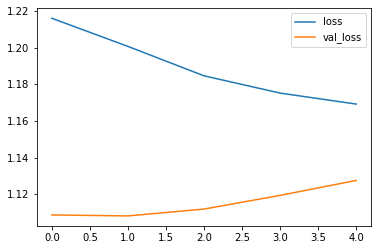

In [55]:
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()

In [56]:
np.min(history.history['val_loss'])

1.1081653833389282

In [57]:
model = keras.models.load_model('/content/09_timeseries_gru_multi_period.keras')

In [58]:
model.evaluate(test_gen, steps=test_steps)

465/465 [==============================] - 19s 38ms/step - loss: 1.2300 - pressure_loss: 0.6147 - temperature_loss: 0.6152


[1.2299652099609375, 0.6147459149360657, 0.6152195930480957]